In [1]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

In [2]:
# Load data

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [4]:
def fill_spend_na(df, fill_value):
    spend_0 = {
            'RoomService': 0,
            'FoodCourt': 0,
            'ShoppingMall': 0,
            'Spa': 0,
            'VRDeck': 0}

    spend_avg = {
            'RoomService': np.mean(df['RoomService']),
            'FoodCourt': np.mean(df['FoodCourt']),
            'ShoppingMall': np.mean(df['ShoppingMall']),
            'Spa': np.mean(df['Spa']),
            'VRDeck': np.mean(df['VRDeck'])}

    if fill_value == 0:
        df = df.fillna(value = spend_0)
    elif fill_value == 'avg':
        df = df.fillna(value = spend_avg)
    else:
        print("Inappropriate fill value provided, only use 0 or avg")
    
    return df

In [5]:
def split_cols(df):
    ''''''
    df['PassengerGroup'] = df['PassengerId'].apply(lambda x: x.split('_')[0])
    df['PassengerNum'] = df['PassengerId'].apply(lambda x: x.split('_')[1])
    df['CabinDeck'] = df['Cabin'].apply(lambda x: str(x).split('/')[0] if bool(re.search('[A-Za-z]/[0-9]+/[A-Za-z]', str(x))) else x)
    df['CabinNum'] = df['Cabin'].apply(lambda x: str(x).split('/')[1] if bool(re.search('[A-Za-z]/[0-9]+/[A-Za-z]', str(x))) else x)
    df['CabinSide'] = df['Cabin'].apply(lambda x: str(x).split('/')[2] if bool(re.search('[A-Za-z]/[0-9]+/[A-Za-z]', str(x))) else x)
    df['FirstName'] = df['Name'].apply(lambda x: str(x).split()[0] if len(str(x)) > 0 else x)
    df['LastName'] = df['Name'].apply(lambda x: str(x).split()[1] if len(str(x).split()) > 1 else x)
    df['TotalSpend'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck'] 
    
    return df


In [6]:
def fill_cryo_na(df):
    '''Replaces NaN CryoSleep for passengers with spending > 0 with False'''
    spend_cols = [
        'RoomService',
        'FoodCourt',
        'ShoppingMall',
        'Spa',
        'VRDeck',
        'TotalSpend']

    # Loop through each spending column, if any spending is found, change CryoSleep to False
    # Otherwise, keep CryoSleep as is
    for col in spend_cols:
        df['CryoSleep'] = np.where(df['CryoSleep'].isnull() & df[col] > 0, False, df['CryoSleep'])
    

In [7]:
def fill_planet_na(df):
    '''
    Fills home planet based on EDA conclusions:
    
    1. Only Europa passengers are ony decks A, B, C, or T
    2. Only those on deck G are from Earth
    3. High majority of those with PSO J318.5-22 destination are from Earth (89%)
    
    Arg: takes dataframe
    Returns: updated dataframe
    
    '''
    
    # Decks A, B, C, T only have Europa passengers
    # Deck D has Mars/Europa only
    # Deck E has all planets
    # Deck F has Earth/Mars
    # People in deck G are all from Earth
    
    home_planets = ['Earth', 'Europa', 'Mars']
    europa_decks = ['A', 'B', 'C', 'T']
    planets = []

    for i in range(len(df)):
        # First if checks for null value
        if df.iloc[i]['CabinDeck'] not in home_planets:
            
            # Check for planet-specific decks
            if df.iloc[i]['CabinDeck'] in europa_decks:
                planets.append('Europa')
            elif df.iloc[i]['CabinDeck'] == 'G':
                planets.append('Earth')
            elif df.iloc[i]['Destination'] == 'PSO J318.5-22' and df.iloc[i]['CabinDeck'] != 'D':
                planets.append('Earth')
            else:
                planets.append(df.iloc[i]['HomePlanet'])
                # planets.append('Unknown')
        else:
            planets.append(df.iloc[i]['HomePlanet'])
    
    df['HomePlanet'] = planets
    
    return df

In [8]:
def fill_cabin_na(df):
    '''Fills cabin nan for Earth sleepers'''
    
    cabins = []
    cabin_decks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']

    for i in range(len(df)):
        cabin = df.iloc[i]['CabinDeck']
        
        # First if checks for null value
        if cabin not in cabin_decks:
            if df.iloc[i]['HomePlanet'] == 'Earth' and df.iloc[i]['CryoSleep'] == True:
                cabins.append('G')
            else:
                cabins.append(df.iloc[i]['CabinDeck'])
        else:
                cabins.append(df.iloc[i]['CabinDeck'])
    
    df['CabinDeck'] = cabins
    
    return df

In [9]:
def clean_df(df, spend_fill):
    '''Run all the nan fill functions'''
    
    df = fill_spend_na(df, spend_fill)
    df = split_cols(df)
    fill_cryo_na(df)
    df = fill_planet_na(df)
    df = fill_cabin_na(df)
    
    return df

In [10]:
# Split for comparison purposes
train = split_cols(train)
df = train.copy()

# Create the cleaned dataframes
# df_0 = filled with $0 for spending columns
df_0 = clean_df(df, 0)

# df_avg = filled with average of col for spending cols
df_avg = clean_df(df, 'avg')


In [11]:
len(df_0) == len(df_avg)

True

In [12]:
df_0[df_0.isnull().T.any()].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpend
count,924.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000
mean,28.568182,232.621034,374.885766,138.893926,314.994560,268.720762,1330.116047
std,14.619801,793.526601,1357.631645,800.550708,1182.515032,1193.851428,2844.722163
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.500000,0.000000,0.000000,0.000000,0.000000,0.000000,652.000000
75%,38.000000,28.000000,20.000000,10.000000,35.500000,17.000000,1223.000000
max,75.000000,14327.000000,17432.000000,23492.000000,15586.000000,24133.000000,24342.000000


In [13]:
df_avg[df_avg.isnull().T.any()].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpend
count,915.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000
mean,28.733333,238.231606,387.181626,143.530203,321.283185,274.832694,1365.059313
std,14.563260,795.928534,1361.742506,803.501308,1186.515699,1198.113980,2854.182881
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,682.500000
75%,38.000000,51.500000,45.750000,20.750000,51.750000,23.000000,1283.500000
max,75.000000,14327.000000,17432.000000,23492.000000,15586.000000,24133.000000,24653.138778


In [14]:
# Throws truth value of a Series is ambiguous error
# train['HomePlanet'] = np.where(
#   (train['HomePlanet'].isnull()) and (train['CabinDeck'] == 'T'), 'Europa', df['CabinDeck'])

# Decision Trees for Feature Engineering

In [15]:
# Dataset split using df_0

tree_features = []

Y_train = df_0['Transported']
X_train = df_0.drop(['Transported'], axis = 1)

In [16]:
def entropy(distribution):
    ''' Computes the entropy index
    # param distribution: list containing distributions
    # return entropy index
    '''
    entropy_index = 0.0
    for probability in distribution:
        logprob = -100.0  # log(0) = -inf so let's approximate it with -100 to avoid an error
        if probability > 0.0: 
            logprob = np.log2(probability)
        entropy_index -= probability * logprob
        
    return entropy_index

In [17]:
def get_parent_distribution(labels):
    ''' Computes parent distirbution
    # param labels: << your turn to comment here >>
    # return: <<your turn to comment here >>
    '''
    # Initialize counters for all labels to zero.
    label_probs = np.array([0.0 for i in range(len(np.unique(labels)))])

    # Iterate over labels in the training data and update counts.
    for label in labels:
        label_probs[label] += 1.0
    
    # Normalize to get a distribution.
    label_probs /= label_probs.sum()
    
    return label_probs

In [18]:
label_probs = get_parent_distribution(Y_train)

print ('Parent distribution', label_probs)
# Compare the label entropy to a uniform distribution.
print ('Parent entropy:', entropy(label_probs))
print ('Uniform entropy:', entropy([1./3, 1./3]))

Parent distribution [0.5 0.5]
Parent entropy: 1.0
Uniform entropy: 1.0566416671474375


In [19]:
# Work with df_0
num_col = [col for col in X_train if X_train[col].dtype != 'object']

In [20]:
# Filter to only numeric columns
num_tree_train = X_train.select_dtypes(include=['float64']).copy()

# Fill NaN age with 0
num_tree_train = num_tree_train.fillna(0)

num_tree_train

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpend
0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,736.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,10383.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,5176.0
4,16.0,303.0,70.0,151.0,565.0,2.0,1091.0
...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,8536.0
8689,18.0,0.0,0.0,0.0,0.0,0.0,0.0
8690,26.0,0.0,0.0,1872.0,1.0,0.0,1873.0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,4637.0


Using a decision stump -- a tree with depth 2:
Feature importances: [0.01754723 0.         0.12491464 0.         0.         0.
 0.85753813]
Accuracy: 0.7386402852870125


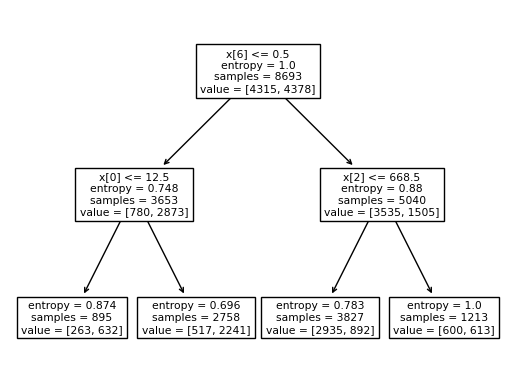

In [21]:
# Numeric columns only decision tree for feature engineering
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2)
dt.fit(num_tree_train, Y_train)
tree.plot_tree(dt)
print ('Using a decision stump -- a tree with depth 2:')
print ('Feature importances:', dt.feature_importances_)
print ('Accuracy:', dt.score(num_tree_train, Y_train))

### Decision tree - numeric fields only results
* Decision tree says age, food court spending, and total spending are most important features
* 73.87% accuracy on training

In [22]:
# Create the categorical only dataset for feature engineering
cat_tree = X_train.select_dtypes(include = ['object']).copy()
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinSide']
cat_tree = cat_tree.filter(cat_features)
cat_tree.fillna('Unknown', axis=1, inplace=True) # fill NaNs

In [23]:
# One-hot encode the df
cat_tree_one_hot = pd.get_dummies(cat_tree, columns = cat_features)

In [24]:
cat_tree_one_hot

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Unknown,CryoSleep_False,CryoSleep_True,CryoSleep_Unknown,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,...,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinDeck_Unknown,CabinSide_P,CabinSide_S,CabinSide_Unknown
0,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
8689,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
8690,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
8691,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


Using a decision stump -- a tree with depth 2:
Feature importances: [0.19573492 0.         0.         0.         0.77717541 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.02708966 0.        ]
Accuracy: 0.7233406188887611


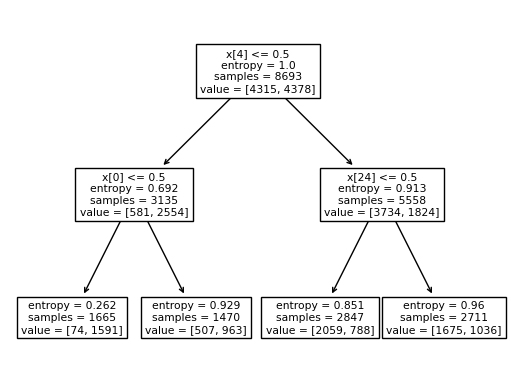

In [25]:
# Run the categorical only df for feature engineering
dt_cat = DecisionTreeClassifier(criterion='entropy', max_depth=2)
dt_cat.fit(cat_tree_one_hot, Y_train)
tree.plot_tree(dt_cat)
print ('Using a decision stump -- a tree with depth 2:')
print ('Feature importances:', dt_cat.feature_importances_)
print ('Accuracy:', dt_cat.score(cat_tree_one_hot, Y_train))

### Decision tree - numeric results

* important features are, from most important to least: cryosleep, planet = earth, cabin side
* training accuracy is 72.33%

# Random Forest Model

In [33]:
def df_for_model(df):
    '''Argument: takes the df to be processed
       Returns: processed df for Random Forest modelling'''
    
    rm_features = ['CryoSleep', 
                   'CabinDeck', 
                   'CabinSide', 
                   'Age', 
                   'TotalSpend']

    df = clean_df(df, 0)
    rm_X = df.filter(rm_features)
    rm_X['Age'] = rm_X['Age'].fillna(0)
    rm_X.fillna('Unknown', inplace=True)
    rm_X = pd.get_dummies(rm_X, columns = ['CryoSleep', 
                                           'CabinDeck', 
                                           'CabinSide'])
    
    return rm_X

In [34]:
rm_X = df_for_model(train)

In [35]:
rm_X['TotalSpend'][rm_X['TotalSpend'] == 'Unknown'].value_counts()

Series([], Name: TotalSpend, dtype: int64)

Using a decision stump -- a tree with depth 3:
Feature importances: [0.         0.70206566 0.         0.         0.         0.
 0.         0.01873186 0.         0.09089024 0.         0.15753517
 0.         0.         0.         0.03077706 0.        ]
Accuracy: 0.741516162429541


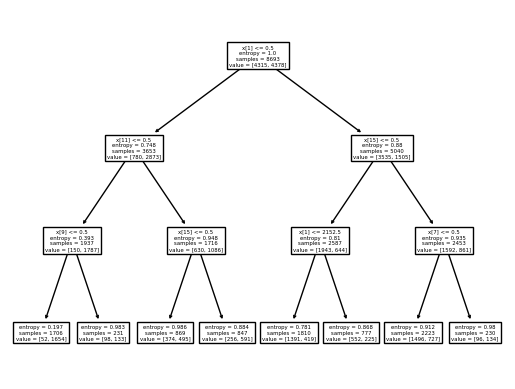

In [36]:
# Run the random forest training set in decision tree to gauge performance
rm_dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)
rm_dt.fit(rm_X, Y_train)
tree.plot_tree(rm_dt)
print ('Using a decision stump -- a tree with depth 3:')
print ('Feature importances:', rm_dt.feature_importances_)
print ('Accuracy:', rm_dt.score(rm_X, Y_train))

In [37]:
# Validation split
rm_train, rm_val, train_labels, val_labels = train_test_split(
    rm_X, Y_train, test_size = 0.5, random_state = 1)

In [38]:
# Set classifier
forest = RandomForestClassifier(n_estimators = 50)

# Fit the model
forest.fit(rm_train, train_labels)

# Get accuracies
print('Training Accuracy:', forest.score(rm_train, train_labels))
print('Validation Accuracy:', forest.score(rm_val, val_labels))

Training Accuracy: 0.9351127473538886
Validation Accuracy: 0.7092247527030136


In [39]:
# Check confusion matrix on predictions
rf_val_predictions = forest.predict(rm_val)

pd.DataFrame(confusion_matrix(val_labels, rf_val_predictions))

,0,1
0,1614,533
1,731,1469


In [40]:
# Show the classification report
print(classification_report(val_labels, rf_val_predictions))

              precision    recall  f1-score   support

       False       0.69      0.75      0.72      2147
        True       0.73      0.67      0.70      2200

    accuracy                           0.71      4347
   macro avg       0.71      0.71      0.71      4347
weighted avg       0.71      0.71      0.71      4347



In [42]:
rm_test = df_for_model(test)

rf_test_predictions = forest.predict(rm_test)

In [46]:
def get_submission_csv(predictions):
    '''Takes predictions and creates dictionary and df for csv export'''
    test_ids = test['PassengerId']
    
    d = {'PassengerID': test_ids,
    'Transported': predictions}
    
    df = pd.DataFrame(data=d)
    
    return df

In [49]:
test_df = get_submission_csv(rf_test_predictions)

In [50]:
test_df

,PassengerID,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False


In [51]:
# Export to csv
# test_df.to_csv('rf_model.csv', index=False)